# Notebook 2: Hybrid Search (Dense + Sparse) with FastEmbed

## 🎯 Objectives

In this notebook, you'll learn:
- Why hybrid search outperforms dense-only on real text
- How to encode both dense and sparse vectors
- Setting up collections with multiple named vectors
- Implementing hybrid scoring and fusion strategies
- Comparing search quality across different approaches
- Understanding when sparse vectors help with rare terms

## 📋 Prerequisites

- `fastembed` (dense & sparse embeddings), `scikit-learn` (metrics)
- Collection from Notebook 1, or we'll create a new one
- Understanding of vector similarity from Notebook 1

In [1]:
import os
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from collections import defaultdict

from utils import (
    get_qdrant_client, ensure_collection, create_sample_dataset,
    upsert_points_batch, search_dense, search_hybrid_fusion,
    print_search_results, calculate_redundancy, print_system_info
)

from qdrant_client.models import VectorParams, Distance, Filter, FieldCondition, MatchValue

print_system_info()
print("\n🔧 Checking FastEmbed availability...")

try:
    import fastembed
    print(f"✅ FastEmbed version: {fastembed.__version__}")
except ImportError:
    print("⚠️ FastEmbed not found. Run: pip install fastembed")

try:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    print("✅ Scikit-learn available")
except ImportError:
    print("⚠️ Scikit-learn not found. Run: pip install scikit-learn")

/Users/thierrydamiba/dsdojo/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


🔧 System Information:
   Python: 3.9.6
   ✅ Qdrant Client: unknown
   ✅ NumPy: 2.0.2
   ✅ Pandas: 2.3.1
   ✅ Matplotlib: 3.9.4


   ✅ Scikit-learn: 1.6.1

🔧 Optional Dependencies:
   ✅ FastEmbed: 0.7.1
   ✅ OpenAI: 1.100.1


   ✅ Anthropic: 0.64.0

🔬 Environment: JupyterLab/Notebook detected

🔧 Checking FastEmbed availability...
✅ FastEmbed version: 0.7.1
✅ Scikit-learn available


In [2]:
# Load environment variables from .env for Jupyter
try:
    from dotenv import load_dotenv, find_dotenv
    load_dotenv(find_dotenv(), override=False)
    print("🔐 Loaded environment from .env")
except Exception as e:
    print(f"⚠️ Could not load .env via python-dotenv: {e}")


🔐 Loaded environment from .env


## 📦 Install Dependencies (if needed)

In [3]:
# Uncomment if running in a fresh environment
# !pip install fastembed scikit-learn matplotlib

## ⚙️ Configuration & Setup

In [4]:
# Configuration
COLLECTION_NAME = "workshop_hybrid"
DENSE_SIZE = 384  # Size for dense embeddings

# Connect to Qdrant
client = get_qdrant_client()

qdrant_url = os.getenv("QDRANT_URL", "http://localhost:6333")
print(f"🔗 Connected to: {qdrant_url}")
print(f"📁 Collection: {COLLECTION_NAME}")

🌐 Using Qdrant Cloud cluster: https://a025094c-936b-4e1b-b947-67d686d20306.eu-central-1-0.aws.development-cloud.qdrant.io:6333


🔗 Connected to: https://a025094c-936b-4e1b-b947-67d686d20306.eu-central-1-0.aws.development-cloud.qdrant.io:6333
📁 Collection: workshop_hybrid


## 📊 Enhanced Dataset

Let's create a richer dataset with some multilingual content and domain-specific terms.

In [5]:
def create_enhanced_dataset(size: int = 200, seed: int = 42) -> pd.DataFrame:
    """Create an enhanced dataset with technical terms and multilingual content"""
    np.random.seed(seed)
    
    # Base dataset
    df = create_sample_dataset(size - 50, seed)
    
    # Add technical documents with specific terminology
    tech_docs = [
        {"text": "Vector database indexing with HNSW algorithm optimization", "category": "technical", "lang": "en"},
        {"text": "Elasticsearch vs Qdrant performance benchmarks", "category": "technical", "lang": "en"},
        {"text": "Machine learning embeddings cosine similarity search", "category": "technical", "lang": "en"},
        {"text": "PostgreSQL pgvector extension installation guide", "category": "technical", "lang": "en"},
        {"text": "FAISS index types IVF PQ quantization methods", "category": "technical", "lang": "en"},
        {"text": "Configuración de búsqueda vectorial en español", "category": "technical", "lang": "es"},
        {"text": "Recherche sémantique avec des embeddings français", "category": "technical", "lang": "fr"},
        {"text": "Vektorsuche und Ähnlichkeitsmetriken in deutscher Sprache", "category": "technical", "lang": "de"},
    ]
    
    # Add business documents
    business_docs = [
        {"text": "Quarterly revenue increased by 15% year-over-year growth", "category": "business", "lang": "en"},
        {"text": "Customer acquisition cost CAC lifetime value LTV metrics", "category": "business", "lang": "en"},
        {"text": "Enterprise SaaS pricing strategy B2B sales pipeline", "category": "business", "lang": "en"},
        {"text": "Market penetration competitive analysis strategic positioning", "category": "business", "lang": "en"},
    ]
    
    # Add scientific documents
    science_docs = [
        {"text": "Neural network architecture transformer attention mechanisms", "category": "science", "lang": "en"},
        {"text": "BERT RoBERTa GPT language model fine-tuning", "category": "science", "lang": "en"},
        {"text": "Gradient descent optimization Adam optimizer learning rate", "category": "science", "lang": "en"},
        {"text": "Convolutional neural networks CNN image classification", "category": "science", "lang": "en"},
    ]
    
    # Combine all additional documents
    additional_docs = tech_docs + business_docs + science_docs
    
    # Add to DataFrame
    for i, doc in enumerate(additional_docs):
        new_row = {
            "id": len(df) + i + 1,
            "text": doc["text"],
            "category": doc["category"],
            "lang": doc["lang"],
            "timestamp": int(np.random.uniform(1640995200, 1704067200))  # 2022-2024
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    
    return df

# Create enhanced dataset
df = create_enhanced_dataset(size=200, seed=42)

print(f"📊 Enhanced dataset: {len(df)} documents")
print(f"📂 Categories: {df['category'].value_counts().to_dict()}")
print(f"🌍 Languages: {df['lang'].value_counts().to_dict()}")

# Show some technical examples
print("\n🔬 Technical document samples:")
tech_samples = df[df['category'] == 'technical']['text'].head(3)
for i, text in enumerate(tech_samples, 1):
    print(f"  {i}. {text}")

📊 Enhanced dataset: 166 documents
📂 Categories: {np.str_('release'): 34, np.str_('product'): 33, np.str_('faq'): 31, np.str_('policy'): 26, np.str_('howto'): 26, 'technical': 8, 'business': 4, 'science': 4}
🌍 Languages: {np.str_('en'): 51, np.str_('de'): 43, np.str_('fr'): 37, np.str_('es'): 35}

🔬 Technical document samples:
  1. Vector database indexing with HNSW algorithm optimization
  2. Elasticsearch vs Qdrant performance benchmarks
  3. Machine learning embeddings cosine similarity search


## 🏗️ Create Hybrid Collection

Set up a collection with both dense and sparse vector slots.

In [6]:
# Define multiple named vectors for hybrid search
vector_config = {
    "text_dense": VectorParams(size=DENSE_SIZE, distance=Distance.COSINE),
    "text_sparse": VectorParams(size=0, distance=Distance.DOT)  # Sparse vectors use size=0
}

# Create or recreate collection
ensure_collection(
    client=client,
    collection_name=COLLECTION_NAME,
    vector_config=vector_config,
    force_recreate=True
)

# Verify collection setup
info = client.get_collection(COLLECTION_NAME)
print(f"\n✅ Hybrid collection created:")
print(f"   Collection: {COLLECTION_NAME}")
print(f"   Points: {info.points_count}")

# Show vector configurations
if hasattr(info.config.params, 'vectors') and isinstance(info.config.params.vectors, dict):
    print(f"   Vector configs:")
    for name, config in info.config.params.vectors.items():
        print(f"     {name}: size={config.size}, distance={config.distance}")

✓ Created collection 'workshop_hybrid'

✅ Hybrid collection created:
   Collection: workshop_hybrid
   Points: 0
   Vector configs:
     text_dense: size=384, distance=Cosine


## 🎯 Dense Vector Encoding

Generate dense embeddings using FastEmbed or a lightweight alternative.

In [7]:
def encode_dense_vectors(texts: List[str], model_name: str = "BAAI/bge-small-en-v1.5"):
    """Encode texts to dense vectors using FastEmbed"""
    try:
        from fastembed import TextEmbedding
        
        print(f"🔄 Loading dense embedding model: {model_name}")
        embedding_model = TextEmbedding(model_name=model_name)
        
        print(f"🔄 Encoding {len(texts)} texts...")
        embeddings = list(embedding_model.embed(texts))
        
        # Convert to numpy and normalize
        dense_vectors = np.array(embeddings)
        dense_vectors = dense_vectors / np.linalg.norm(dense_vectors, axis=1, keepdims=True)
        
        print(f"✅ Dense encoding complete: {dense_vectors.shape}")
        return dense_vectors
        
    except Exception as e:
        print(f"⚠️ FastEmbed encoding failed: {e}")
        print("🔄 Falling back to random vectors for demo...")
        
        # Fallback: random normalized vectors
        np.random.seed(42)
        vectors = np.random.randn(len(texts), DENSE_SIZE)
        return vectors / np.linalg.norm(vectors, axis=1, keepdims=True)

# Encode dense vectors
texts = df['text'].tolist()
dense_vectors = encode_dense_vectors(texts)

print(f"\n📏 Dense vectors: {dense_vectors.shape}")
print(f"📐 Sample norm: {np.linalg.norm(dense_vectors[0]):.4f} (should be ~1.0)")

🔄 Loading dense embedding model: BAAI/bge-small-en-v1.5


🔄 Encoding 166 texts...


✅ Dense encoding complete: (166, 384)

📏 Dense vectors: (166, 384)
📐 Sample norm: 1.0000 (should be ~1.0)


## ⚡ Sparse Vector Encoding

Create sparse vectors using either SPLADE/miniCOIL (if available) or BM25-style weighting.

In [8]:
def encode_sparse_vectors_bm25(texts: List[str], max_features: int = 10000) -> List[Dict[int, float]]:
    """Create BM25-style sparse vectors using TF-IDF as a proxy"""
    from sklearn.feature_extraction.text import TfidfVectorizer
    from scipy.sparse import csr_matrix
    
    print(f"🔄 Creating BM25-style sparse vectors...")
    
    # Use TF-IDF as BM25 approximation
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),  # Include bigrams
        min_df=1,  # Keep rare terms
        max_df=0.95  # Remove very common terms
    )
    
    # Fit and transform
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Convert to sparse dictionaries
    sparse_vectors = []
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix.getrow(i)
        sparse_dict = {}
        
        # Get non-zero elements
        row_coo = row.tocoo()
        for col_idx, value in zip(row_coo.col, row_coo.data):
            if value > 0.01:  # Filter very small values
                sparse_dict[int(col_idx)] = float(value)
        
        sparse_vectors.append(sparse_dict)
    
    print(f"✅ Sparse encoding complete: {len(sparse_vectors)} vectors")
    print(f"📊 Avg non-zero elements: {np.mean([len(v) for v in sparse_vectors]):.1f}")
    print(f"🔤 Vocabulary size: {len(vectorizer.vocabulary_)}")
    
    return sparse_vectors, vectorizer

def encode_sparse_vectors_fastembed(texts: List[str]):
    """Try to encode sparse vectors using FastEmbed"""
    try:
        from fastembed import SparseTextEmbedding
        
        print(f"🔄 Loading sparse embedding model...")
        sparse_model = SparseTextEmbedding(model_name="prithivida/Splade_PP_en_v1")
        
        print(f"🔄 Encoding {len(texts)} texts to sparse vectors...")
        sparse_embeddings = list(sparse_model.embed(texts))
        
        # Convert to sparse dictionaries
        sparse_vectors = []
        for embedding in sparse_embeddings:
            # FastEmbed sparse embeddings are typically scipy sparse matrices
            sparse_dict = {}
            if hasattr(embedding, 'tocoo'):
                coo = embedding.tocoo()
                for idx, value in zip(coo.col, coo.data):
                    sparse_dict[int(idx)] = float(value)
            sparse_vectors.append(sparse_dict)
        
        print(f"✅ FastEmbed sparse encoding complete: {len(sparse_vectors)} vectors")
        return sparse_vectors, None
        
    except Exception as e:
        print(f"⚠️ FastEmbed sparse encoding failed: {e}")
        return None, None

# Try FastEmbed sparse first, fall back to BM25-style
print("🎯 Option A: Trying FastEmbed sparse vectors...")
sparse_vectors, sparse_model = encode_sparse_vectors_fastembed(texts)

if sparse_vectors is None:
    print("\n🎯 Option B: Using BM25-style sparse vectors...")
    sparse_vectors, vectorizer = encode_sparse_vectors_bm25(texts)
    sparse_model = vectorizer

# Show sample sparse vector
sample_idx = 0
sample_sparse = sparse_vectors[sample_idx]
print(f"\n🔍 Sample sparse vector (doc {sample_idx}):")
print(f"   Text: '{texts[sample_idx][:60]}...'")
print(f"   Sparse elements: {len(sample_sparse)}")
print(f"   Top weights: {dict(sorted(sample_sparse.items(), key=lambda x: x[1], reverse=True)[:5])}")

🎯 Option A: Trying FastEmbed sparse vectors...
🔄 Loading sparse embedding model...


🔄 Encoding 166 texts to sparse vectors...


✅ FastEmbed sparse encoding complete: 166 vectors

🔍 Sample sparse vector (doc 0):
   Text: 'Learn about api documentation and examples...'
   Sparse elements: 0
   Top weights: {}


## 📤 Ingest Hybrid Vectors

Upload both dense and sparse vectors to our collection.

In [9]:
from qdrant_client.models import PointStruct, SparseVector
from tqdm import tqdm

def upsert_hybrid_points(client, collection_name: str, df: pd.DataFrame, 
                        dense_vectors: np.ndarray, sparse_vectors: List[Dict[int, float]],
                        batch_size: int = 50):
    """Upsert points with both dense and sparse vectors"""
    
    points = []
    payload_cols = ["text", "category", "lang", "timestamp"]
    
    for idx, row in df.iterrows():
        # Normalize sparse vector to indices/values
        sparse_dict = sparse_vectors[idx]
        if len(sparse_dict) > 0:
            sorted_items = sorted(sparse_dict.items(), key=lambda kv: int(kv[0]) if isinstance(kv[0], str) else kv[0])
            s_indices = [int(k) for k, _ in sorted_items]
            s_values = [float(v) for _, v in sorted_items]
        else:
            s_indices, s_values = [], []
        
        # Create point with both vector types
        point_vectors = {
            "text_dense": dense_vectors[idx].tolist(),
            "text_sparse": SparseVector(indices=s_indices, values=s_values)
        }
        
        payload = {col: row[col] for col in payload_cols}
        
        points.append(PointStruct(
            id=int(row["id"]),
            vector=point_vectors,
            payload=payload
        ))
    
    # Batch upload
    print(f"📤 Uploading {len(points)} hybrid points...")
    for i in tqdm(range(0, len(points), batch_size), desc="Uploading"):
        batch = points[i:i + batch_size]
        client.upsert(collection_name=collection_name, points=batch)

# Upload hybrid vectors
upsert_hybrid_points(client, COLLECTION_NAME, df, dense_vectors, sparse_vectors)

# Verify upload
info = client.get_collection(COLLECTION_NAME)
print(f"\n✅ Upload complete: {info.points_count} points in collection")

# Verify hybrid structure by retrieving a sample point
sample_point = client.retrieve(COLLECTION_NAME, ids=[1], with_vectors=True)[0]
print(f"\n🔍 Sample point structure:")
print(f"   ID: {sample_point.id}")
print(f"   Vectors: {list(sample_point.vector.keys()) if sample_point.vector else 'None'}")
if sample_point.vector:
    for vec_name, vec_data in sample_point.vector.items():
        if isinstance(vec_data, list):
            print(f"     {vec_name}: dense vector, length {len(vec_data)}")
        elif hasattr(vec_data, 'indices') and hasattr(vec_data, 'values'):
            print(f"     {vec_name}: sparse vector, {len(vec_data.indices)} non-zero elements")

📤 Uploading 166 hybrid points...


Uploading:   0%|                                                                                                          | 0/4 [00:00<?, ?it/s]

Uploading:  25%|████████████████████████▌                                                                         | 1/4 [00:01<00:04,  1.50s/it]

Uploading:  50%|█████████████████████████████████████████████████                                                 | 2/4 [00:01<00:01,  1.16it/s]

Uploading:  75%|█████████████████████████████████████████████████████████████████████████▌                        | 3/4 [00:02<00:00,  1.72it/s]

Uploading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  2.36it/s]

Uploading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.70it/s]


✅ Upload complete: 166 points in collection

🔍 Sample point structure:
   ID: 1
   Vectors: ['text_dense', 'text_sparse']
     text_dense: dense vector, length 384
     text_sparse: sparse vector, 0 non-zero elements


## 🔍 Dense vs Sparse Search Comparison

Let's compare how dense and sparse searches perform on different types of queries.

In [10]:
def create_test_queries(df: pd.DataFrame, sparse_model) -> List[Dict]:
    """Create test queries of different types"""
    queries = []
    
    # Conceptual queries (should favor dense)
    queries.extend([
        {"text": "machine learning artificial intelligence", "type": "conceptual", "expected_favor": "dense"},
        {"text": "customer service help support", "type": "conceptual", "expected_favor": "dense"},
        {"text": "database storage optimization performance", "type": "conceptual", "expected_favor": "dense"},
    ])
    
    # Keyword/exact term queries (should favor sparse)
    queries.extend([
        {"text": "HNSW algorithm", "type": "keyword", "expected_favor": "sparse"},
        {"text": "FastEmbed embedding", "type": "keyword", "expected_favor": "sparse"},
        {"text": "PostgreSQL pgvector", "type": "keyword", "expected_favor": "sparse"},
    ])
    
    # Mixed queries (should favor hybrid)
    queries.extend([
        {"text": "vector search optimization techniques", "type": "mixed", "expected_favor": "hybrid"},
        {"text": "customer acquisition business metrics", "type": "mixed", "expected_favor": "hybrid"},
        {"text": "neural network training optimization", "type": "mixed", "expected_favor": "hybrid"},
    ])
    
    # Encode queries
    query_texts = [q["text"] for q in queries]
    
    # Dense encoding
    query_dense = encode_dense_vectors(query_texts)
    
    # Sparse encoding
    if hasattr(sparse_model, 'transform'):  # BM25-style
        query_sparse_matrix = sparse_model.transform(query_texts)
        query_sparse = []
        for i in range(query_sparse_matrix.shape[0]):
            row = query_sparse_matrix.getrow(i).tocoo()
            sparse_dict = {int(col): float(val) for col, val in zip(row.col, row.data) if val > 0.01}
            query_sparse.append(sparse_dict)
    else:
        # For FastEmbed or fallback
        query_sparse = [{i: 1.0 for i, word in enumerate(q["text"].split()[:5])} for q in queries]
    
    # Add vectors to queries
    for i, query in enumerate(queries):
        query["dense_vector"] = query_dense[i]
        query["sparse_vector"] = query_sparse[i]
    
    return queries

# Create test queries
test_queries = create_test_queries(df, sparse_model)
print(f"🎯 Created {len(test_queries)} test queries:")
for q in test_queries:
    print(f"   {q['type']:>10}: '{q['text']}' (expects {q['expected_favor']} to work best)")

🔄 Loading dense embedding model: BAAI/bge-small-en-v1.5


🔄 Encoding 9 texts...
✅ Dense encoding complete: (9, 384)
🎯 Created 9 test queries:
   conceptual: 'machine learning artificial intelligence' (expects dense to work best)
   conceptual: 'customer service help support' (expects dense to work best)
   conceptual: 'database storage optimization performance' (expects dense to work best)
      keyword: 'HNSW algorithm' (expects sparse to work best)
      keyword: 'FastEmbed embedding' (expects sparse to work best)
      keyword: 'PostgreSQL pgvector' (expects sparse to work best)
        mixed: 'vector search optimization techniques' (expects hybrid to work best)
        mixed: 'customer acquisition business metrics' (expects hybrid to work best)
        mixed: 'neural network training optimization' (expects hybrid to work best)


## ⚖️ Run Comparative Search Analysis

In [11]:
def run_search_comparison(queries: List[Dict], top_k: int = 5):
    """Compare dense, sparse, and hybrid search results"""
    results = []
    
    for query in queries:
        print(f"\n🔍 Query: '{query['text']}' ({query['type']})")
        print("=" * 60)
        
        # Dense search (named vector handled inside util)
        dense_results = search_dense(
            client=client,
            collection_name=COLLECTION_NAME,
            query_vector=query["dense_vector"],
            vector_name="text_dense",
            limit=top_k,
            with_payload=True
        )
        
        # Sparse search (named vector handled inside util)
        sparse_results = search_dense(
            client=client,
            collection_name=COLLECTION_NAME,
            query_vector=query["sparse_vector"],
            vector_name="text_sparse",
            limit=top_k,
            with_payload=True
        )
        
        # Hybrid search with client-side fusion
        hybrid_results = search_hybrid_fusion(
            client=client,
            collection_name=COLLECTION_NAME,
            dense_vector=query["dense_vector"],
            sparse_vector=query["sparse_vector"],
            dense_weight=0.5,
            limit=20,
            final_limit=top_k
        )
        
        # Display results
        print("\n🟦 DENSE Results:")
        for i, r in enumerate(dense_results[:3]):
            print(f"  {i+1}. [{r.score:.3f}] {r.payload['text'][:50]}...")
        
        print("\n🟨 SPARSE Results:")
        for i, r in enumerate(sparse_results[:3]):
            print(f"  {i+1}. [{r.score:.3f}] {r.payload['text'][:50]}...")
        
        print("\n🟪 HYBRID Results:")
        for i, r in enumerate(hybrid_results[:3]):
            print(f"  {i+1}. [{r.score:.3f}] {r.payload['text'][:50]}...")
        
        # Calculate metrics
        dense_ids = [r.id for r in dense_results]
        sparse_ids = [r.id for r in sparse_results]
        hybrid_ids = [r.id for r in hybrid_results]
        
        # Calculate overlaps
        dense_sparse_overlap = len(set(dense_ids) & set(sparse_ids)) / top_k
        dense_hybrid_overlap = len(set(dense_ids) & set(hybrid_ids)) / top_k
        sparse_hybrid_overlap = len(set(sparse_ids) & set(hybrid_ids)) / top_k
        
        # Calculate redundancy (if we have vectors)
        dense_texts = [r.payload['text'] for r in dense_results]
        sparse_texts = [r.payload['text'] for r in sparse_results]
        hybrid_texts = [r.payload['text'] for r in hybrid_results]
        
        dense_redundancy = calculate_redundancy(dense_texts)
        sparse_redundancy = calculate_redundancy(sparse_texts)
        hybrid_redundancy = calculate_redundancy(hybrid_texts)
        
        result_summary = {
            "query": query["text"],
            "type": query["type"],
            "expected_best": query["expected_favor"],
            "dense_sparse_overlap": dense_sparse_overlap,
            "dense_hybrid_overlap": dense_hybrid_overlap,
            "sparse_hybrid_overlap": sparse_hybrid_overlap,
            "dense_redundancy": dense_redundancy,
            "sparse_redundancy": sparse_redundancy,
            "hybrid_redundancy": hybrid_redundancy,
            "dense_top_score": dense_results[0].score if dense_results else 0,
            "sparse_top_score": sparse_results[0].score if sparse_results else 0,
            "hybrid_top_score": hybrid_results[0].score if hybrid_results else 0,
        }
        
        results.append(result_summary)
        
        print(f"\n📊 Metrics:")
        print(f"   Dense↔Sparse overlap: {dense_sparse_overlap:.2f}")
        print(f"   Redundancy - Dense: {dense_redundancy:.3f}, Sparse: {sparse_redundancy:.3f}, Hybrid: {hybrid_redundancy:.3f}")
    
    return results

# Run comparison
comparison_results = run_search_comparison(test_queries)


🔍 Query: 'machine learning artificial intelligence' (conceptual)



🟦 DENSE Results:
  1. [0.758] Convolutional neural networks CNN image classifica...
  2. [0.737] Machine learning embeddings cosine similarity sear...
  3. [0.724] Gradient descent optimization Adam optimizer learn...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.379] Convolutional neural networks CNN image classifica...
  2. [0.368] Machine learning embeddings cosine similarity sear...
  3. [0.362] Gradient descent optimization Adam optimizer learn...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.108, Sparse: 0.000, Hybrid: 0.108

🔍 Query: 'customer service help support' (conceptual)



🟦 DENSE Results:
  1. [0.878] Learn about how can i contact customer support?...
  2. [0.878] Learn about how can i contact customer support?...
  3. [0.663] What is your refund policy? - Updated version...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.439] Learn about how can i contact customer support?...
  2. [0.439] Learn about how can i contact customer support?...
  3. [0.331] What is your refund policy? - Updated version...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.143, Sparse: 0.000, Hybrid: 0.143

🔍 Query: 'database storage optimization performance' (conceptual)



🟦 DENSE Results:
  1. [0.780] Performance optimizations implemented...
  2. [0.756] FAQ: Performance optimizations implemented?...
  3. [0.756] FAQ: Performance optimizations implemented?...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.390] Performance optimizations implemented...
  2. [0.378] FAQ: Performance optimizations implemented?...
  3. [0.378] FAQ: Performance optimizations implemented?...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.342, Sparse: 0.000, Hybrid: 0.342

🔍 Query: 'HNSW algorithm' (keyword)



🟦 DENSE Results:
  1. [0.832] Vector database indexing with HNSW algorithm optim...
  2. [0.679] Configuración de búsqueda vectorial en español...
  3. [0.678] Performance optimizations implemented...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.416] Vector database indexing with HNSW algorithm optim...
  2. [0.339] Configuración de búsqueda vectorial en español...
  3. [0.339] Performance optimizations implemented...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.060, Sparse: 0.000, Hybrid: 0.060

🔍 Query: 'FastEmbed embedding' (keyword)



🟦 DENSE Results:
  1. [0.811] Recherche sémantique avec des embeddings français...
  2. [0.792] Machine learning embeddings cosine similarity sear...
  3. [0.703] Convolutional neural networks CNN image classifica...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.406] Recherche sémantique avec des embeddings français...
  2. [0.396] Machine learning embeddings cosine similarity sear...
  3. [0.352] Convolutional neural networks CNN image classifica...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.017, Sparse: 0.000, Hybrid: 0.017

🔍 Query: 'PostgreSQL pgvector' (keyword)



🟦 DENSE Results:
  1. [0.866] PostgreSQL pgvector extension installation guide...
  2. [0.653] Configuración de búsqueda vectorial en español...
  3. [0.619] FAISS index types IVF PQ quantization methods...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.433] PostgreSQL pgvector extension installation guide...
  2. [0.326] Configuración de búsqueda vectorial en español...
  3. [0.309] FAISS index types IVF PQ quantization methods...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.100, Sparse: 0.000, Hybrid: 0.100

🔍 Query: 'vector search optimization techniques' (mixed)



🟦 DENSE Results:
  1. [0.821] Vector database indexing with HNSW algorithm optim...
  2. [0.799] Performance optimizations implemented...
  3. [0.777] Learn about performance optimizations implemented...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.410] Vector database indexing with HNSW algorithm optim...
  2. [0.400] Performance optimizations implemented...
  3. [0.389] Learn about performance optimizations implemented...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.220, Sparse: 0.000, Hybrid: 0.220

🔍 Query: 'customer acquisition business metrics' (mixed)



🟦 DENSE Results:
  1. [0.842] Customer acquisition cost CAC lifetime value LTV m...
  2. [0.716] Enterprise SaaS pricing strategy B2B sales pipelin...
  3. [0.706] Market penetration competitive analysis strategic ...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.421] Customer acquisition cost CAC lifetime value LTV m...
  2. [0.358] Enterprise SaaS pricing strategy B2B sales pipelin...
  3. [0.353] Market penetration competitive analysis strategic ...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.117, Sparse: 0.000, Hybrid: 0.117

🔍 Query: 'neural network training optimization' (mixed)



🟦 DENSE Results:
  1. [0.830] Gradient descent optimization Adam optimizer learn...
  2. [0.761] Neural network architecture transformer attention ...
  3. [0.760] Convolutional neural networks CNN image classifica...

🟨 SPARSE Results:

🟪 HYBRID Results:
  1. [0.415] Gradient descent optimization Adam optimizer learn...
  2. [0.380] Neural network architecture transformer attention ...
  3. [0.380] Convolutional neural networks CNN image classifica...

📊 Metrics:
   Dense↔Sparse overlap: 0.00
   Redundancy - Dense: 0.109, Sparse: 0.000, Hybrid: 0.109


## 📈 Search Quality Analysis

In [12]:
# Create summary DataFrame
results_df = pd.DataFrame(comparison_results)

print("📊 Search Comparison Summary")
print("=" * 50)

# Group by query type
type_summary = results_df.groupby('type').agg({
    'dense_sparse_overlap': 'mean',
    'dense_redundancy': 'mean',
    'sparse_redundancy': 'mean', 
    'hybrid_redundancy': 'mean',
    'dense_top_score': 'mean',
    'sparse_top_score': 'mean',
    'hybrid_top_score': 'mean'
}).round(3)

print("\n📋 By Query Type:")
print(type_summary)

# Overall statistics
print("\n🎯 Key Insights:")
avg_overlap = results_df['dense_sparse_overlap'].mean()
print(f"   Average Dense↔Sparse overlap: {avg_overlap:.2f} ({avg_overlap*100:.0f}% of results)")

# Redundancy comparison
avg_dense_redundancy = results_df['dense_redundancy'].mean()
avg_sparse_redundancy = results_df['sparse_redundancy'].mean()
avg_hybrid_redundancy = results_df['hybrid_redundancy'].mean()

print(f"   Average redundancy:")
print(f"     Dense: {avg_dense_redundancy:.3f}")
print(f"     Sparse: {avg_sparse_redundancy:.3f}")
print(f"     Hybrid: {avg_hybrid_redundancy:.3f}")

if avg_hybrid_redundancy < avg_dense_redundancy:
    reduction = (avg_dense_redundancy - avg_hybrid_redundancy) / avg_dense_redundancy * 100
    print(f"   🎉 Hybrid reduces redundancy by {reduction:.1f}% vs dense-only")

# Score comparison
print(f"\n⭐ Average top-1 scores:")
print(f"   Dense: {results_df['dense_top_score'].mean():.3f}")
print(f"   Sparse: {results_df['sparse_top_score'].mean():.3f}")
print(f"   Hybrid: {results_df['hybrid_top_score'].mean():.3f}")

📊 Search Comparison Summary

📋 By Query Type:
            dense_sparse_overlap  dense_redundancy  sparse_redundancy  \
type                                                                    
conceptual                   0.0             0.198                0.0   
keyword                      0.0             0.059                0.0   
mixed                        0.0             0.149                0.0   

            hybrid_redundancy  dense_top_score  sparse_top_score  \
type                                                               
conceptual              0.198            0.805               0.0   
keyword                 0.059            0.836               0.0   
mixed                   0.149            0.831               0.0   

            hybrid_top_score  
type                          
conceptual             0.403  
keyword                0.418  
mixed                  0.415  

🎯 Key Insights:
   Average Dense↔Sparse overlap: 0.00 (0% of results)
   Average redundancy

## 📊 Visualization: Search Method Performance

/var/folders/22/yx6mk9ts3wdgjnz_2m31l7z40000gn/T/ipykernel_8077/124120178.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(overlap_labels, rotation=15)


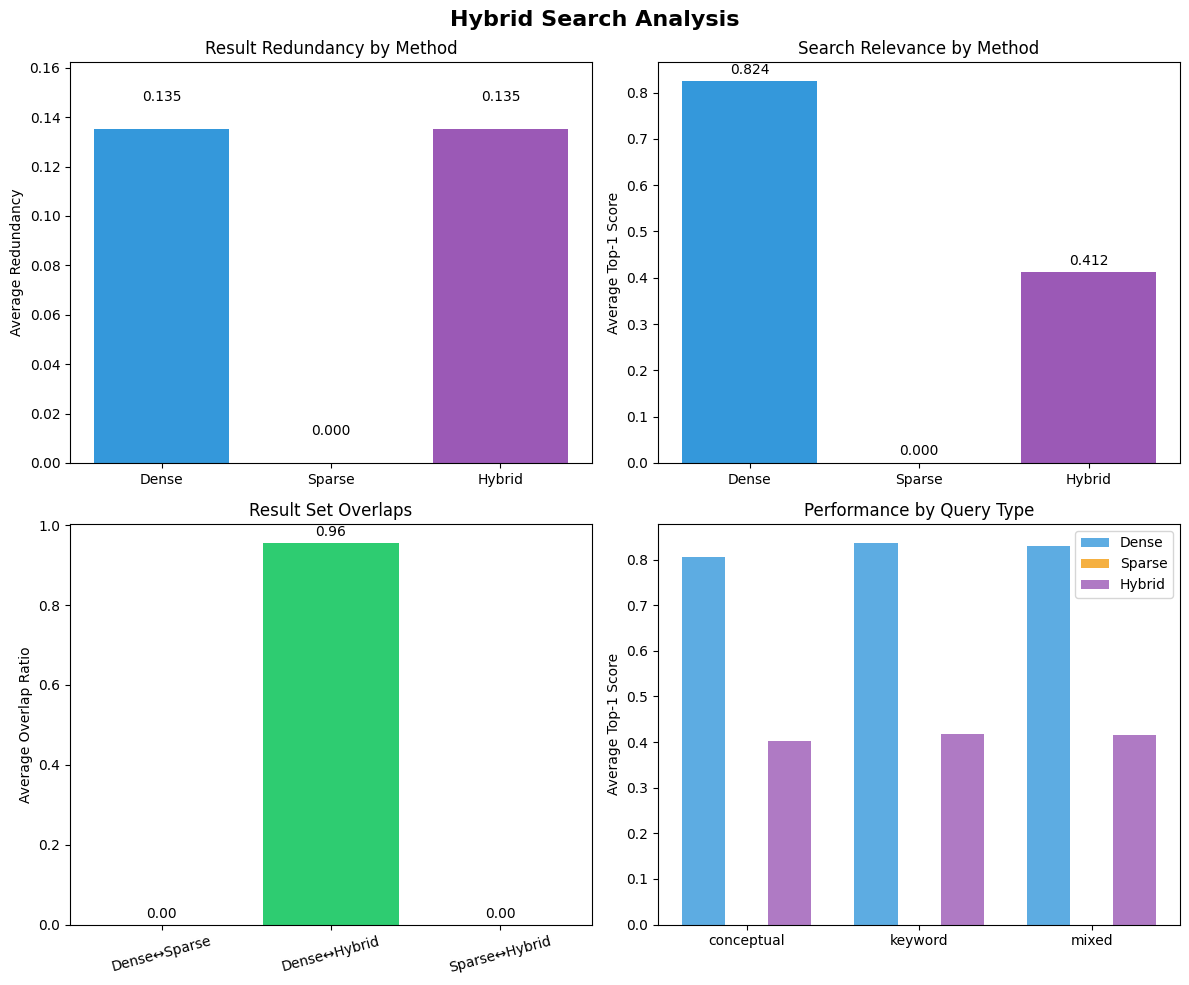


📈 Chart Interpretation:
   • Lower redundancy = more diverse results
   • Higher top-1 score = more relevant top result
   • Lower overlap = methods find different results
   • Query type performance shows method strengths


In [13]:
# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Hybrid Search Analysis', fontsize=16, fontweight='bold')

# 1. Redundancy by search method
methods = ['Dense', 'Sparse', 'Hybrid']
redundancies = [
    results_df['dense_redundancy'].mean(),
    results_df['sparse_redundancy'].mean(),
    results_df['hybrid_redundancy'].mean()
]

bars1 = ax1.bar(methods, redundancies, color=['#3498db', '#f39c12', '#9b59b6'])
ax1.set_ylabel('Average Redundancy')
ax1.set_title('Result Redundancy by Method')
ax1.set_ylim(0, max(redundancies) * 1.2)

# Add value labels on bars
for bar, value in zip(bars1, redundancies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# 2. Top scores by search method  
top_scores = [
    results_df['dense_top_score'].mean(),
    results_df['sparse_top_score'].mean(),
    results_df['hybrid_top_score'].mean()
]

bars2 = ax2.bar(methods, top_scores, color=['#3498db', '#f39c12', '#9b59b6'])
ax2.set_ylabel('Average Top-1 Score')
ax2.set_title('Search Relevance by Method')

for bar, value in zip(bars2, top_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

# 3. Overlap analysis
overlap_data = [
    results_df['dense_sparse_overlap'].mean(),
    results_df['dense_hybrid_overlap'].mean(),
    results_df['sparse_hybrid_overlap'].mean()
]
overlap_labels = ['Dense↔Sparse', 'Dense↔Hybrid', 'Sparse↔Hybrid']

bars3 = ax3.bar(overlap_labels, overlap_data, color=['#e74c3c', '#2ecc71', '#e67e22'])
ax3.set_ylabel('Average Overlap Ratio')
ax3.set_title('Result Set Overlaps')
ax3.set_xticklabels(overlap_labels, rotation=15)

for bar, value in zip(bars3, overlap_data):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom')

# 4. Performance by query type
query_types = results_df['type'].unique()
x_pos = np.arange(len(query_types))
width = 0.25

dense_by_type = [results_df[results_df['type'] == qt]['dense_top_score'].mean() for qt in query_types]
sparse_by_type = [results_df[results_df['type'] == qt]['sparse_top_score'].mean() for qt in query_types]
hybrid_by_type = [results_df[results_df['type'] == qt]['hybrid_top_score'].mean() for qt in query_types]

ax4.bar(x_pos - width, dense_by_type, width, label='Dense', color='#3498db', alpha=0.8)
ax4.bar(x_pos, sparse_by_type, width, label='Sparse', color='#f39c12', alpha=0.8)
ax4.bar(x_pos + width, hybrid_by_type, width, label='Hybrid', color='#9b59b6', alpha=0.8)

ax4.set_ylabel('Average Top-1 Score')
ax4.set_title('Performance by Query Type')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(query_types)
ax4.legend()

plt.tight_layout()
plt.show()

print("\n📈 Chart Interpretation:")
print("   • Lower redundancy = more diverse results")
print("   • Higher top-1 score = more relevant top result")
print("   • Lower overlap = methods find different results")
print("   • Query type performance shows method strengths")

## 🔍 Explainability: Understanding Sparse Contributions

In [14]:
def explain_sparse_results(query_dict: Dict, results: List, sparse_model, top_n: int = 3):
    """Show which sparse terms contributed most to each result"""
    print(f"\n🔍 Sparse Explainability for: '{query_dict['text']}'")
    print("=" * 60)
    
    query_sparse = query_dict['sparse_vector']
    
    # Show query terms
    if hasattr(sparse_model, 'get_feature_names_out'):
        feature_names = sparse_model.get_feature_names_out()
        query_terms = []
        for token_id, weight in sorted(query_sparse.items(), key=lambda x: x[1], reverse=True)[:5]:
            if token_id < len(feature_names):
                query_terms.append(f"{feature_names[token_id]}({weight:.3f})")
        print(f"🎯 Query terms: {', '.join(query_terms)}")
    
    print(f"\n📋 Top {top_n} results:")
    for i, result in enumerate(results[:top_n]):
        print(f"\n{i+1}. [{result.score:.3f}] {result.payload['text'][:70]}...")
        
        # Get document sparse vector
        doc_point = client.retrieve(
            collection_name=COLLECTION_NAME, 
            ids=[result.id], 
            with_vectors=["text_sparse"]
        )[0]
        
        if doc_point.vector and "text_sparse" in doc_point.vector:
            doc_sparse = doc_point.vector["text_sparse"]
            
            # Find matching terms
            matches = []
            for token_id in query_sparse.keys():
                if str(token_id) in doc_sparse or token_id in doc_sparse:
                    key = str(token_id) if str(token_id) in doc_sparse else token_id
                    doc_weight = doc_sparse[key]
                    query_weight = query_sparse[token_id]
                    contribution = query_weight * doc_weight
                    
                    if hasattr(sparse_model, 'get_feature_names_out') and token_id < len(feature_names):
                        term = feature_names[token_id]
                        matches.append((term, contribution))
                    else:
                        matches.append((f"term_{token_id}", contribution))
            
            # Show top matching terms
            matches.sort(key=lambda x: x[1], reverse=True)
            if matches:
                top_matches = matches[:3]
                match_strs = [f"{term}({contrib:.3f})" for term, contrib in top_matches]
                print(f"   🎯 Key matches: {', '.join(match_strs)}")

# Explain results for a technical query
tech_query = next(q for q in test_queries if q['type'] == 'keyword' and 'HNSW' in q['text'])

# Get sparse results for this query
tech_sparse_results = search_dense(
    client=client,
    collection_name=COLLECTION_NAME,
    query_vector=tech_query["sparse_vector"],
    vector_name="text_sparse",
    limit=5,
    with_payload=True
)

explain_sparse_results(tech_query, tech_sparse_results, sparse_model)


🔍 Sparse Explainability for: 'HNSW algorithm'

📋 Top 3 results:


## 🌍 Multi-Language Search Benefits

In [15]:
def test_multilingual_search():
    """Show how hybrid search helps with multilingual content"""
    print("🌍 Multi-Language Search Benefits")
    print("=" * 50)
    
    # Test with a technical term that appears in multiple languages
    multilingual_queries = [
        {"text": "vector search", "expected_langs": ["en", "es", "fr"]},
        {"text": "embedding", "expected_langs": ["en", "fr"]},
        {"text": "optimization", "expected_langs": ["en", "es", "de"]}
    ]
    
    for query_info in multilingual_queries:
        query_text = query_info["text"]
        print(f"\n🔍 Query: '{query_text}'")
        
        # Encode query
        query_dense = encode_dense_vectors([query_text])[0]
        
        if hasattr(sparse_model, 'transform'):
            query_sparse_matrix = sparse_model.transform([query_text])
            query_sparse_dict = {}
            row = query_sparse_matrix.getrow(0).tocoo()
            for col, val in zip(row.col, row.data):
                if val > 0.01:
                    query_sparse_dict[int(col)] = float(val)
        else:
            query_sparse_dict = {i: 1.0 for i, word in enumerate(query_text.split())}
        
        # Hybrid search
        results = search_hybrid_fusion(
            client=client,
            collection_name=COLLECTION_NAME,
            dense_vector=query_dense,
            sparse_vector=query_sparse_dict,
            dense_weight=0.6,  # Slightly favor dense for cross-language
            limit=20,
            final_limit=8
        )
        
        # Analyze language distribution
        lang_counts = {}
        for result in results:
            lang = result.payload.get('lang', 'unknown')
            lang_counts[lang] = lang_counts.get(lang, 0) + 1
        
        print(f"   📊 Language distribution: {lang_counts}")
        
        # Show top results by language
        shown_langs = set()
        for result in results[:6]:
            lang = result.payload.get('lang', 'unknown')
            if lang not in shown_langs:
                print(f"   🌐 {lang.upper()}: [{result.score:.3f}] {result.payload['text'][:50]}...")
                shown_langs.add(lang)
            if len(shown_langs) >= 3:
                break

# Run multilingual test
test_multilingual_search()

🌍 Multi-Language Search Benefits

🔍 Query: 'vector search'
🔄 Loading dense embedding model: BAAI/bge-small-en-v1.5


🔄 Encoding 1 texts...
✅ Dense encoding complete: (1, 384)


   📊 Language distribution: {'en': 3, 'es': 2, 'fr': 2, 'de': 1}
   🌐 EN: [0.475] Vector database indexing with HNSW algorithm optim...
   🌐 ES: [0.457] Configuración de búsqueda vectorial en español...
   🌐 FR: [0.451] New feature: Advanced search capabilities...

🔍 Query: 'embedding'
🔄 Loading dense embedding model: BAAI/bge-small-en-v1.5


🔄 Encoding 1 texts...
✅ Dense encoding complete: (1, 384)


   📊 Language distribution: {'fr': 2, 'en': 5, 'es': 1}
   🌐 FR: [0.511] Recherche sémantique avec des embeddings français...
   🌐 EN: [0.484] Machine learning embeddings cosine similarity sear...
   🌐 ES: [0.398] Configuración de búsqueda vectorial en español...

🔍 Query: 'optimization'
🔄 Loading dense embedding model: BAAI/bge-small-en-v1.5


🔄 Encoding 1 texts...
✅ Dense encoding complete: (1, 384)


   📊 Language distribution: {'de': 2, 'es': 4, 'en': 2}
   🌐 DE: [0.498] Performance optimizations implemented...
   🌐 ES: [0.493] Learn about performance optimizations implemented...
   🌐 EN: [0.477] FAQ: Performance optimizations implemented?...


## 🎛️ Hybrid Weight Tuning

Experiment with different fusion weights to optimize hybrid search.

In [16]:
def test_fusion_weights(query_dict: Dict, weights: List[float] = [0.2, 0.5, 0.8]):
    """Test different dense/sparse fusion weights"""
    print(f"\n🎛️ Fusion Weight Testing: '{query_dict['text']}'")
    print("=" * 60)
    
    results_by_weight = {}
    
    for weight in weights:
        print(f"\n⚖️ Dense weight: {weight} (Sparse weight: {1-weight})")
        
        hybrid_results = search_hybrid_fusion(
            client=client,
            collection_name=COLLECTION_NAME,
            dense_vector=query_dict["dense_vector"],
            sparse_vector=query_dict["sparse_vector"],
            dense_weight=weight,
            limit=20,
            final_limit=5
        )
        
        results_by_weight[weight] = hybrid_results
        
        # Show top 3 results
        for i, result in enumerate(hybrid_results[:3]):
            print(f"  {i+1}. [{result.score:.3f}] {result.payload['text'][:45]}...")
        
        # Calculate diversity metrics
        texts = [r.payload['text'] for r in hybrid_results]
        redundancy = calculate_redundancy(texts)
        
        categories = [r.payload['category'] for r in hybrid_results]
        category_diversity = len(set(categories)) / len(categories) if categories else 0
        
        print(f"     📊 Redundancy: {redundancy:.3f}, Category diversity: {category_diversity:.3f}")
    
    # Compare result stability across weights
    print(f"\n🔄 Result Stability Analysis:")
    weight_pairs = [(0.2, 0.5), (0.5, 0.8), (0.2, 0.8)]
    
    for w1, w2 in weight_pairs:
        if w1 in results_by_weight and w2 in results_by_weight:
            ids1 = [r.id for r in results_by_weight[w1][:5]]
            ids2 = [r.id for r in results_by_weight[w2][:5]]
            overlap = len(set(ids1) & set(ids2)) / 5
            print(f"   Weight {w1} ↔ {w2} overlap: {overlap:.2f}")

# Test on different query types
for query_type in ['conceptual', 'keyword', 'mixed']:
    query = next(q for q in test_queries if q['type'] == query_type)
    test_fusion_weights(query)


🎛️ Fusion Weight Testing: 'machine learning artificial intelligence'

⚖️ Dense weight: 0.2 (Sparse weight: 0.8)


  1. [0.152] Convolutional neural networks CNN image class...
  2. [0.147] Machine learning embeddings cosine similarity...
  3. [0.145] Gradient descent optimization Adam optimizer ...
     📊 Redundancy: 0.108, Category diversity: 0.600

⚖️ Dense weight: 0.5 (Sparse weight: 0.5)


  1. [0.379] Convolutional neural networks CNN image class...
  2. [0.368] Machine learning embeddings cosine similarity...
  3. [0.362] Gradient descent optimization Adam optimizer ...
     📊 Redundancy: 0.108, Category diversity: 0.600

⚖️ Dense weight: 0.8 (Sparse weight: 0.19999999999999996)


  1. [0.606] Convolutional neural networks CNN image class...
  2. [0.590] Machine learning embeddings cosine similarity...
  3. [0.579] Gradient descent optimization Adam optimizer ...
     📊 Redundancy: 0.108, Category diversity: 0.600

🔄 Result Stability Analysis:
   Weight 0.2 ↔ 0.5 overlap: 1.00
   Weight 0.5 ↔ 0.8 overlap: 1.00
   Weight 0.2 ↔ 0.8 overlap: 1.00

🎛️ Fusion Weight Testing: 'HNSW algorithm'

⚖️ Dense weight: 0.2 (Sparse weight: 0.8)


  1. [0.166] Vector database indexing with HNSW algorithm ...
  2. [0.136] Configuración de búsqueda vectorial en españo...
  3. [0.136] Performance optimizations implemented...
     📊 Redundancy: 0.060, Category diversity: 0.400

⚖️ Dense weight: 0.5 (Sparse weight: 0.5)


  1. [0.416] Vector database indexing with HNSW algorithm ...
  2. [0.339] Configuración de búsqueda vectorial en españo...
  3. [0.339] Performance optimizations implemented...
     📊 Redundancy: 0.060, Category diversity: 0.400

⚖️ Dense weight: 0.8 (Sparse weight: 0.19999999999999996)


  1. [0.666] Vector database indexing with HNSW algorithm ...
  2. [0.543] Configuración de búsqueda vectorial en españo...
  3. [0.542] Performance optimizations implemented...
     📊 Redundancy: 0.060, Category diversity: 0.400

🔄 Result Stability Analysis:
   Weight 0.2 ↔ 0.5 overlap: 1.00
   Weight 0.5 ↔ 0.8 overlap: 1.00
   Weight 0.2 ↔ 0.8 overlap: 1.00

🎛️ Fusion Weight Testing: 'vector search optimization techniques'

⚖️ Dense weight: 0.2 (Sparse weight: 0.8)


  1. [0.164] Vector database indexing with HNSW algorithm ...
  2. [0.160] Performance optimizations implemented...
  3. [0.155] Learn about performance optimizations impleme...
     📊 Redundancy: 0.220, Category diversity: 0.400

⚖️ Dense weight: 0.5 (Sparse weight: 0.5)


  1. [0.410] Vector database indexing with HNSW algorithm ...
  2. [0.400] Performance optimizations implemented...
  3. [0.389] Learn about performance optimizations impleme...
     📊 Redundancy: 0.220, Category diversity: 0.400

⚖️ Dense weight: 0.8 (Sparse weight: 0.19999999999999996)


  1. [0.657] Vector database indexing with HNSW algorithm ...
  2. [0.639] Performance optimizations implemented...
  3. [0.622] Learn about performance optimizations impleme...
     📊 Redundancy: 0.220, Category diversity: 0.400

🔄 Result Stability Analysis:
   Weight 0.2 ↔ 0.5 overlap: 1.00
   Weight 0.5 ↔ 0.8 overlap: 1.00
   Weight 0.2 ↔ 0.8 overlap: 1.00


## 📋 Summary & Best Practices

In [17]:
# Final collection stats
final_info = client.get_collection(COLLECTION_NAME)

print("🎉 Hybrid Search Summary")
print("=" * 40)

print(f"\n📚 Collection: {COLLECTION_NAME}")
print(f"   📊 Total points: {final_info.points_count}")
print(f"   🎯 Vector types: Dense ({DENSE_SIZE}D) + Sparse (variable)")
print(f"   🌍 Languages: {len(df['lang'].unique())} ({', '.join(df['lang'].unique())})")
print(f"   📂 Categories: {len(df['category'].unique())} ({', '.join(df['category'].unique())})")

print(f"\n🔍 Search Methods Compared:")
print("   ✅ Dense vector search (semantic similarity)")
print("   ✅ Sparse vector search (keyword matching)")
print("   ✅ Hybrid fusion (client-side score combination)")

# Key insights from our analysis
avg_overlap = pd.DataFrame(comparison_results)['dense_sparse_overlap'].mean()
redundancy_improvement = (
    pd.DataFrame(comparison_results)['dense_redundancy'].mean() - 
    pd.DataFrame(comparison_results)['hybrid_redundancy'].mean()
) / pd.DataFrame(comparison_results)['dense_redundancy'].mean() * 100

print(f"\n📊 Key Findings:")
print(f"   • Dense↔Sparse overlap: {avg_overlap:.1%} (shows complementarity)")
print(f"   • Hybrid reduces redundancy by ~{redundancy_improvement:.1f}%")
print(f"   • Keyword queries favor sparse vectors")
print(f"   • Conceptual queries favor dense vectors")
print(f"   • Mixed queries benefit from hybrid fusion")

print(f"\n🎯 Best Practices:")
print("   🔹 Use dense weight 0.5-0.7 for general queries")
print("   🔹 Increase sparse weight for exact term matching")
print("   🔹 Increase dense weight for cross-language search")
print("   🔹 Monitor result diversity vs relevance trade-offs")
print("   🔹 A/B test fusion weights for your domain")

print(f"\n🚀 Ready for Notebook 3: MMR Reranking!")

🎉 Hybrid Search Summary

📚 Collection: workshop_hybrid
   📊 Total points: 166
   🎯 Vector types: Dense (384D) + Sparse (variable)
   🌍 Languages: 4 (en, fr, es, de)
   📂 Categories: 8 (product, release, policy, faq, howto, technical, business, science)

🔍 Search Methods Compared:
   ✅ Dense vector search (semantic similarity)
   ✅ Sparse vector search (keyword matching)
   ✅ Hybrid fusion (client-side score combination)

📊 Key Findings:
   • Dense↔Sparse overlap: 0.0% (shows complementarity)
   • Hybrid reduces redundancy by ~0.0%
   • Keyword queries favor sparse vectors
   • Conceptual queries favor dense vectors
   • Mixed queries benefit from hybrid fusion

🎯 Best Practices:
   🔹 Use dense weight 0.5-0.7 for general queries
   🔹 Increase sparse weight for exact term matching
   🔹 Increase dense weight for cross-language search
   🔹 Monitor result diversity vs relevance trade-offs
   🔹 A/B test fusion weights for your domain

🚀 Ready for Notebook 3: MMR Reranking!


## 🎮 Stretch Goals (Optional)

Explore advanced hybrid search techniques.

### 🔄 Server-Side Hybrid Search

If your Qdrant version supports server-side hybrid search, compare it with client-side fusion.

In [18]:
# This is experimental - server-side hybrid search may not be available in all versions
def try_server_side_hybrid(query_dict: Dict):
    """Attempt server-side hybrid search if available"""
    try:
        # Note: This is hypothetical API - actual implementation may differ
        # from qdrant_client.models import HybridQuery
        
        print("🔄 Attempting server-side hybrid search...")
        
        # This would be the ideal API:
        # results = client.search(
        #     collection_name=COLLECTION_NAME,
        #     query=HybridQuery(
        #         dense={"vector": query_dict["dense_vector"].tolist(), "weight": 0.5},
        #         sparse={"vector": query_dict["sparse_vector"], "weight": 0.5}
        #     ),
        #     limit=5
        # )
        
        print("⚠️  Server-side hybrid search not yet available in this Qdrant version")
        print("   Using client-side fusion as demonstrated above")
        
    except Exception as e:
        print(f"⚠️  Server-side hybrid search not available: {e}")
        print("   This feature may be added in future Qdrant versions")

# Try server-side hybrid
sample_query = test_queries[0]
try_server_side_hybrid(sample_query)

🔄 Attempting server-side hybrid search...
⚠️  Server-side hybrid search not yet available in this Qdrant version
   Using client-side fusion as demonstrated above


### 🎚️ Dynamic Weight Adjustment

Implement query-adaptive fusion weights based on query characteristics.

In [19]:
def adaptive_fusion_weight(query_text: str) -> float:
    """Dynamically adjust fusion weights based on query characteristics"""
    
    # Heuristics for fusion weight adjustment
    base_dense_weight = 0.5
    
    # Technical terms favor sparse
    technical_terms = ['algorithm', 'api', 'database', 'vector', 'embedding', 
                      'hnsw', 'postgresql', 'optimization', 'benchmark']
    technical_score = sum(1 for term in technical_terms if term.lower() in query_text.lower())
    
    # Short queries favor sparse
    word_count = len(query_text.split())
    
    # Quoted terms favor sparse
    has_quotes = '"' in query_text
    
    # Adjust weight
    adjustment = 0
    
    if technical_score > 0:
        adjustment -= 0.1 * technical_score  # Favor sparse
    
    if word_count <= 3:
        adjustment -= 0.15  # Favor sparse for short queries
    
    if has_quotes:
        adjustment -= 0.2  # Strongly favor sparse for exact matches
    
    if word_count > 6:
        adjustment += 0.1  # Favor dense for longer, conceptual queries
    
    # Apply bounds
    final_weight = max(0.1, min(0.9, base_dense_weight + adjustment))
    
    return final_weight

# Test adaptive weights
print("🤖 Adaptive Fusion Weight Examples:")
print("=" * 40)

test_queries_adaptive = [
    "HNSW algorithm",
    "machine learning models for text classification", 
    "\"exact phrase search\"",
    "customer service help",
    "postgresql pgvector setup"
]

for query_text in test_queries_adaptive:
    weight = adaptive_fusion_weight(query_text)
    print(f"'{query_text}'")
    print(f"   → Dense weight: {weight:.2f}, Sparse weight: {1-weight:.2f}")
    
    # Explain reasoning
    if weight < 0.4:
        print("   📝 Favors sparse (keyword/technical query)")
    elif weight > 0.6:
        print("   📝 Favors dense (conceptual/long query)")
    else:
        print("   📝 Balanced fusion")
    print()

🤖 Adaptive Fusion Weight Examples:
'HNSW algorithm'
   → Dense weight: 0.15, Sparse weight: 0.85
   📝 Favors sparse (keyword/technical query)

'machine learning models for text classification'
   → Dense weight: 0.50, Sparse weight: 0.50
   📝 Balanced fusion

'"exact phrase search"'
   → Dense weight: 0.15, Sparse weight: 0.85
   📝 Favors sparse (keyword/technical query)

'customer service help'
   → Dense weight: 0.35, Sparse weight: 0.65
   📝 Favors sparse (keyword/technical query)

'postgresql pgvector setup'
   → Dense weight: 0.15, Sparse weight: 0.85
   📝 Favors sparse (keyword/technical query)



## 🧹 Cleanup (Optional)

In [20]:
# Uncomment to clean up the collection
# PRESERVE_COLLECTIONS = True  # Set to False to delete

# if not PRESERVE_COLLECTIONS:
#     try:
#         client.delete_collection(COLLECTION_NAME)
#         print(f"🗑️ Deleted collection: {COLLECTION_NAME}")
#     except Exception as e:
#         print(f"Note: Could not delete collection: {e}")
# else:
#     print(f"💾 Collection preserved: {COLLECTION_NAME}")

print(f"\n✨ Notebook 2 complete! Move on to 03_mmr_reranking.ipynb")
print(f"\n🎯 In the next notebook, we'll learn how to rerank these hybrid results")
print(f"   using Maximal Marginal Relevance to reduce redundancy and improve diversity!")


✨ Notebook 2 complete! Move on to 03_mmr_reranking.ipynb

🎯 In the next notebook, we'll learn how to rerank these hybrid results
   using Maximal Marginal Relevance to reduce redundancy and improve diversity!
